In [2]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Property Assessment 2018
- Data is pulled from City of Edmonton Open Data portal.
- `nb` stands for neighbourhood
- The `ward` and `neighbourhood ID` columns are dropped from the DataFrame
    - The ward information is not understandable by the average homeowner
    - The neighbourhood name and ID are synonymous and present in all datasets 

### Set the correct data types for each of the remaining columns and reorder columns

In [3]:
col_names = ['acc_num', 'suite', 'number', 'street', 'value', 'class', 
             'nb_id', 'nb', 'ward', 'garage', 'lat', 'long']
col_dtypes = {'acc_num':np.int32, 'suite':object, 'number':object, 'street':object, 
              'value':np.int32, 'class':'category', 'nb':'category'}
col_keep = ['acc_num', 'nb', 'class', 'value', 'suite', 'number', 'street',
             'garage', 'lat', 'long']

df = pd.read_csv('Property_Assessment_Data__Current_Calendar_Year_.csv', 
                 header=0, names=col_names, dtype=col_dtypes, 
                 true_values='Y', false_values='N')[col_keep]

# Property Information 2018

In [4]:
col_names = ['acc_num', 'suite', 'number', 'street', 'legal_desc', 'zoning', 
             'lot_size', 'year_built', 'nb_id', 'nb', 'ward', 'lat', 'long']
col_dtypes = {'acc_num':np.int32, 'zoning':object, 'lot_size':object, 'year_built':object}
col_keep = ['acc_num', 'zoning', 'lot_size', 'year_built', 'nb']

df_info = pd.read_csv('Property_Information_Data__Current_Calendar_Year_.csv', 
                 header=0, names=col_names, dtype=col_dtypes, low_memory=False)[col_keep]

### Remove and verify the number of null neighbourhood ID records
- This dataset contains one record without a neighbourhood ID.
    - This record has a substantially lower property assessment value.
    - This record represents an outlier in the nearly 400,000 records

In [5]:
df_null = df[df.nb.isnull()]
df_info_null = df_info[df_info.nb.isnull()]

df_cleaned = df[~df.nb.isnull()]
df_info_cleaned = df_info[~df_info.nb.isnull()]
print('The number of null neighbourhood records in df = {}'.format(len(df_null)))
print('The number of null neighbourhood records in df_info = {}'.format(len(df_info_null)))

The number of null neighbourhood records in df = 1
The number of null neighbourhood records in df_info = 1


## Merge the data and info DataFrames

### Filter the data for only the residential entries. To eliminate large malls and high-rises.

**It has been found through exploratory data analysis that residential zonings are more reliable than Edmonton's class designators**

In [6]:
df_info_cleaned = df_info_cleaned[['acc_num', 'zoning', 'lot_size', 'year_built']]

df_clean = df_cleaned.merge(df_info_cleaned, on='acc_num')

df_clean['zoning'] = df_clean['zoning'].fillna('')
df_index = df_clean.zoning.str.contains('R')
df_clean = df_clean[df_index]

df_clean = df_clean[df_clean['class'] == 'Residential']

df_clean = df_clean[df_clean['value'] > 20000]

df_clean = df_clean[df_clean['value'] < 10000000]

## Missing street data is also found to be indicative of inconsequential records
- (a) Any lookup system would be reliant on accurate street data for indentification of the property
- (b) Many of these records have significantly low or high valuations (on Google Maps, these locations seem to be research facilites, walkways, signage, community buildings, etc.)

In [7]:
df_street_null = df_clean[df_clean.street.isnull()]

df_clean = df_clean[~df_clean.street.isnull()]

print('The number of null street records in df_clean = {}'.format(len(df_street_null)))

The number of null street records in df_clean = 205


# Edmonton Criminal Incidents by Neibourhood
- Data is pulled from City of Edmonton Open Data portal.
- The two data frames will be joined on `nb` neighbourhood name.

### Rename the columns more logically and to align with `df_cleaned`

In [8]:
col_list = ['nb', 'violation', 'year', 'quarter', 'month', 'num_incidents']
col_dtypes = {'nb':'category', 'violation':'category', 'year':str, 'month':str}
col_order = ['nb', 'violation', 'num_incidents', 'year', 'month', 'quarter']

df_crime = pd.read_csv('EPS_Neighbourhood_Criminal_Incidents.csv', header=0, 
                      names=col_list, dtype=col_dtypes)[col_order]

### Convert `year` and `month` to a datetime column

In [9]:
datetime = pd.to_datetime(df_crime['year'] + '-' + df_crime['month'])

df_crime['record_month'] = datetime

df_crime = df_crime[['nb', 'violation', 'num_incidents', 'record_month']]

df_crime.set_index('record_month', inplace=True)

### Splice the crime data for only 2018 to avoid overexposing crime incidents in older neighbourhoods.

In [10]:
crime2018 = df_crime.loc['2018']
incidents2018 = crime2018.pivot_table(values='num_incidents', index='nb', 
                                      columns='violation', fill_value=0, aggfunc='sum')

### Merge the two dataframes to generate a complete and cleaned dataset
- Reset the index and drop the old index

- Filter on just the most recent crime data (2018)

In [11]:
property_assess = df_clean.merge(incidents2018, left_on='nb', right_index=True)
property_assess.reset_index(inplace=True)
property_assess.drop('index', axis=1, inplace=True)
property_assess = property_assess.sort_values(by='value', ascending=True)

### Assessment of property outliers

- Scatter plots
- order data

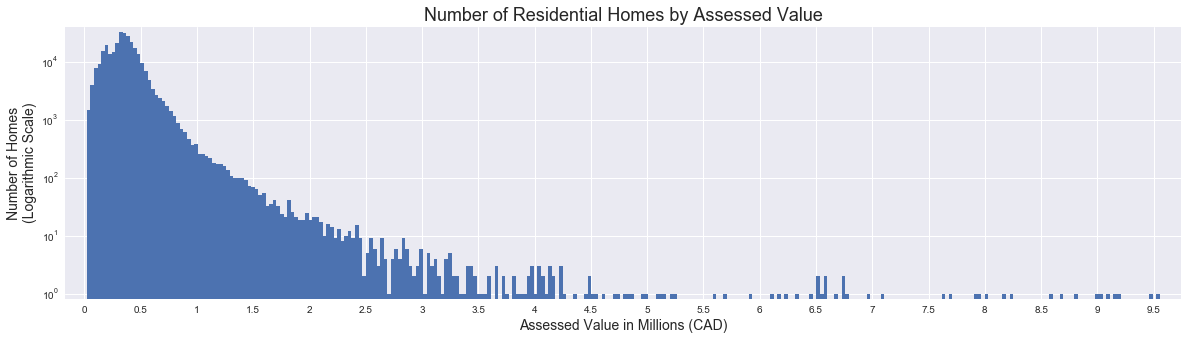

In [12]:
sns.set()
# Generate a plot of residential homes and minimize outliers.
plt.figure(figsize=(20,5))
ax = property_assess['value'].plot(kind='hist', bins=300, logy=True)
ax.set_xlabel('Assessed Value in Millions (CAD)', fontsize=14)
ax.set_xticks([i for i in range(0,10000000,500000)])
ax.set_xticklabels([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10])
ax.set_ylabel('Number of Homes\n(Logarithmic Scale)', fontsize=14)
ax.set_title('Number of Residential Homes by Assessed Value', fontsize=18)
plt.margins(0.02)

plt.show()

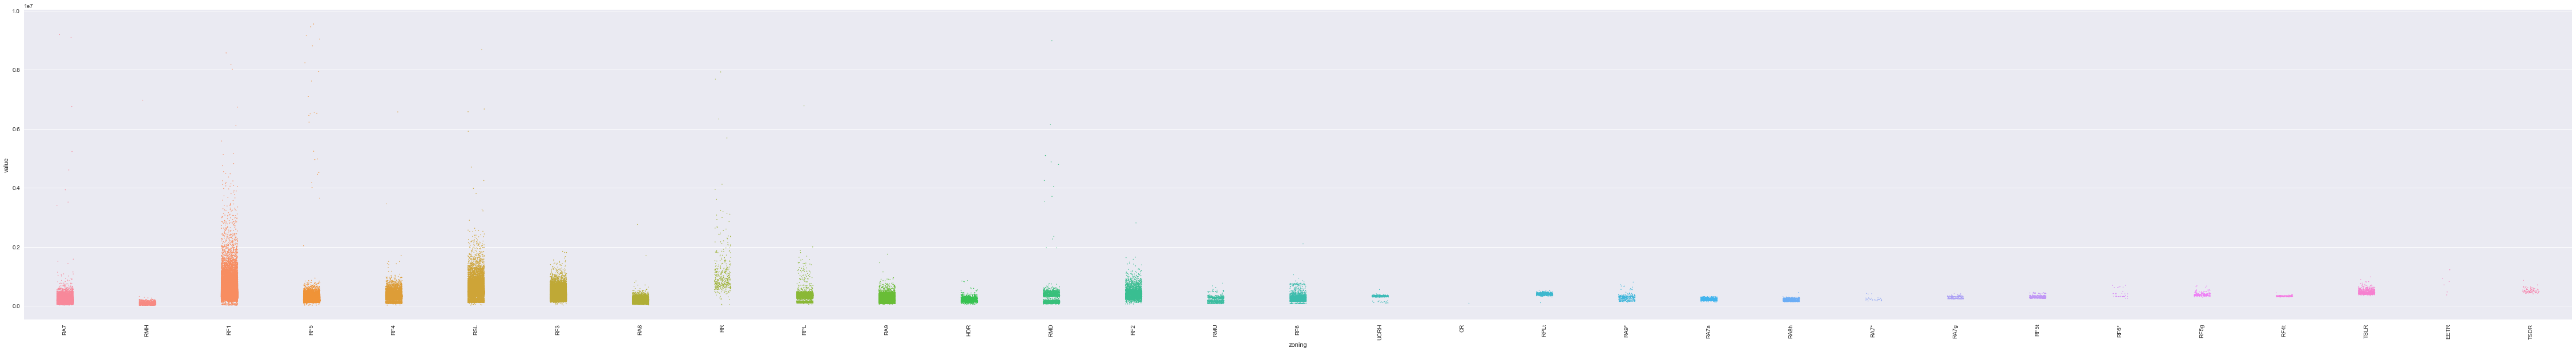

In [13]:
plt.figure(1, figsize=(80,10))

# Overlay a strip plot on the violin plot
sns.stripplot(x='zoning', y='value', data=property_assess, size=1.5, jitter=True)

plt.xticks(rotation=90)

# Display the plot
plt.savefig('zoning values.png')
plt.show()

## Some property assessments are for future developments:

![Aster Neighbourhood Investigation](Aster _NSP_Consolidation.pdf)

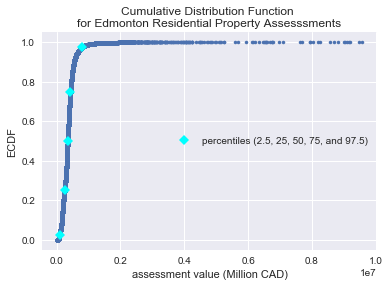

In [14]:
%run stats_func.py

value = property_assess['value']

# Specify array of percentiles: percentiles
percentiles = np.array([2.5, 25, 50, 75, 97.5])

# Compute percentiles
ptiles = np.percentile(value, percentiles)

x_res, y_res = ecdf(value)
_ = plt.plot(x_res, y_res, marker='.', linestyle='none')
_ = plt.xlabel('assessment value (Million CAD)')
_ = plt.ylabel('ECDF')
_ = plt.title('Cumulative Distribution Function \nfor Edmonton Residential Property Assesssments')

_ = plt.plot(ptiles, percentiles/100, marker='D', color='cyan', 
             linestyle='none', label='percentiles (2.5, 25, 50, 75, and 97.5)')
_ = plt.legend(loc='center right')

plt.show()

## Reshaping of data for analysis

In [12]:
df_grouped = df_cleaned.groupby(['nb']).mean()
df_grouped = df_grouped[['value']]

In [13]:
neighbourhood_assess = df_grouped.merge(incidents2018, left_on='nb', right_index=True)

nb_assess = neighbourhood_assess.reset_index()

nb_assess = nb_assess[nb_assess['value'] < 4400000]

df_index = ~nb_assess.nb.str.contains('INDUSTRIAL')
nb_assess = nb_assess[df_index]

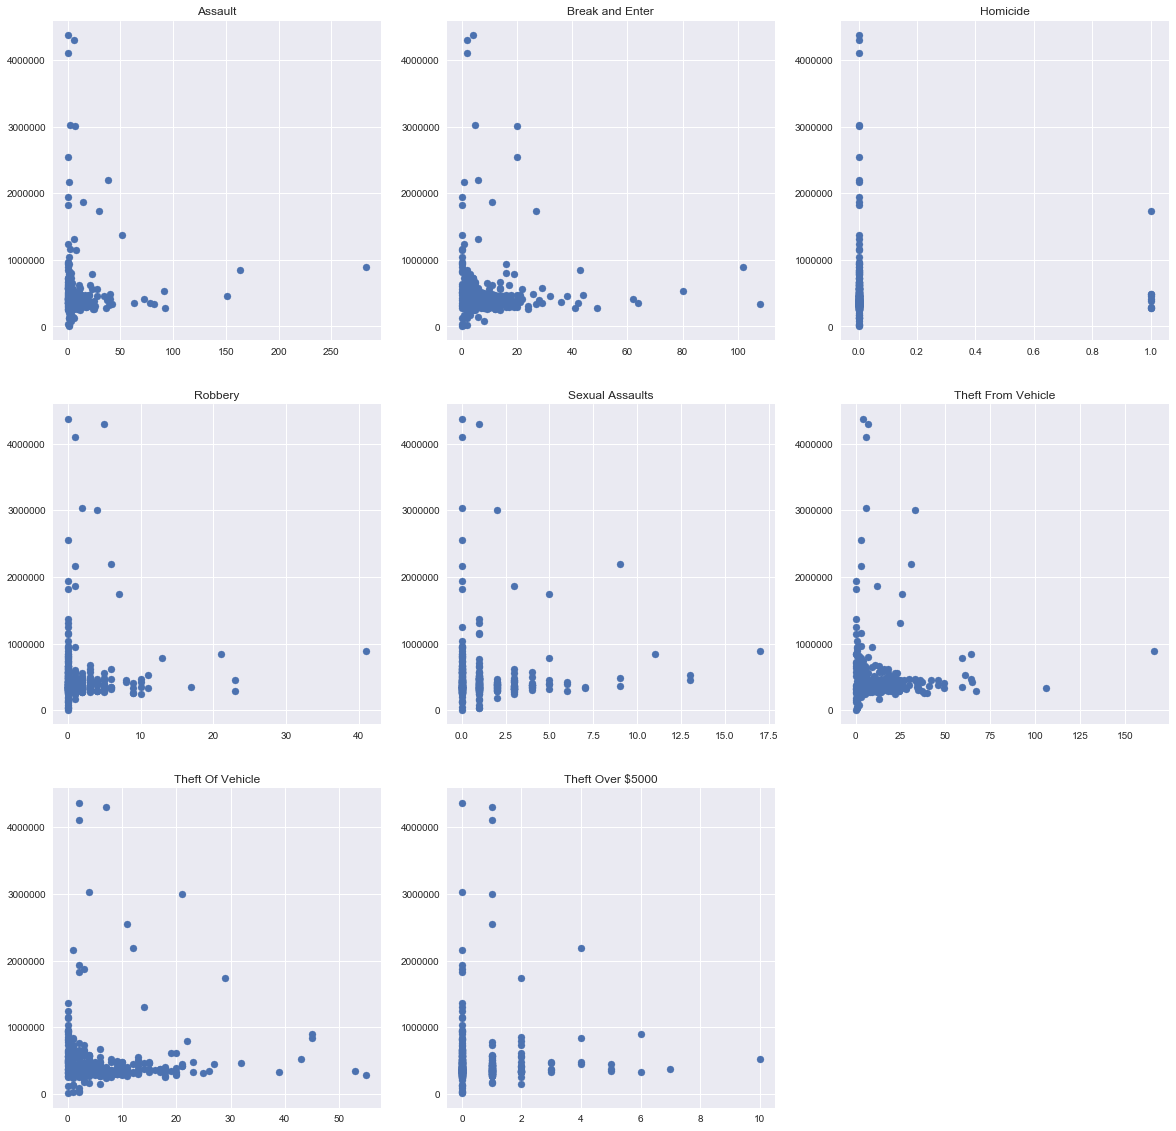

In [17]:
plt.figure(figsize=(20,20))

plt.subplot(3,3,1)
plt.scatter(x='Assault', y='value', data=nb_assess)
plt.title('Assault')

plt.subplot(3,3,2)
plt.scatter(x='Break and Enter', y='value', data=nb_assess)
plt.title('Break and Enter')

plt.subplot(3,3,3)
plt.scatter(x='Homicide', y='value', data=nb_assess)
plt.title('Homicide')

plt.subplot(3,3,4)
plt.scatter(x='Robbery', y='value', data=nb_assess)
plt.title('Robbery')

plt.subplot(3,3,5)
plt.scatter(x='Sexual Assaults', y='value', data=nb_assess)
plt.title('Sexual Assaults')

plt.subplot(3,3,6)
plt.scatter(x='Theft From Vehicle', y='value', data=nb_assess)
plt.title('Theft From Vehicle')

plt.subplot(3,3,7)
plt.scatter(x='Theft Of Vehicle', y='value', data=nb_assess)
plt.title('Theft Of Vehicle')

plt.subplot(3,3,8)
plt.scatter(x='Theft Over $5000', y='value', data=nb_assess)
plt.title('Theft Over $5000')

plt.show()

## Example Analysis of Incident Type:

In [18]:
def incident_dist(incident):
    '''A function that takes an criminal incident designator,
    (Assault, Break and Enter, Homicide, Robbery, Sexual Assults, Theft From Vehicle,
    Theft Of Vehicle, Theft Over $5000) and returns a histogram distribution.
    '''
    
    print('The maximum number of ' + incident + ' for any neighbourhood in Edmonton 2018 is: \n' 
          + str(nb_assess[incident].max()))
    print('\nThe neighbourhood with the most ' + incident + ' in 2018 is/are: \n' 
          + str(nb_assess[nb_assess[incident] == nb_assess[incident].max()].nb))
    
    ax = nb_assess[incident].plot(kind='hist',range=(0,nb_assess[incident].max()), bins=100, title=incident)
    ax.set_ylabel('Number of Neighbourhoods')
    ax.set_xlabel('Number of Incidents in 2018')
plt.show()

The maximum number of Homicide for any neighbourhood in Edmonton 2018 is: 
1

The neighbourhood with the most Homicide in 2018 is/are: 
2         ALBERTA AVENUE
32             BELVEDERE
56     CALLINGWOOD SOUTH
157             HOLYROOD
163            INGLEWOOD
168             KEHEEWIN
174              KILDARE
283            ROSENTHAL
305        SPRUCE AVENUE
Name: nb, dtype: category
Categories (395, object): [ABBOTTSFIELD, ALBANY, ALBERTA AVENUE, ALBERTA PARK INDUSTRIAL, ..., MILL WOODS PARK, RIVER VALLEY LAURIER, RIVER VALLEY LESSARD NORTH, GLENRIDDING RAVINE]


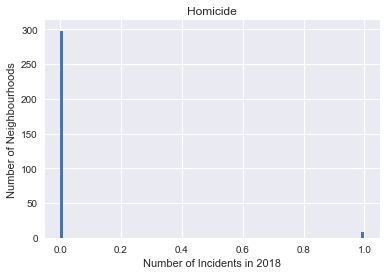

In [19]:
incident_dist('Homicide')

In [15]:
col_names = ['acc_num', 'lot_size', 'year', 'suite', 'number', 'street', 
             'legal_land', 'garage', 'nb', 'value', 'class', 'year_built', 'zoning']
col_dtypes = {'acc_num':np.int32, 'lot_size':np.float32, 'year':np.int32, 
              'suite':object, 'number':object, 'street':object, 
              'value':np.int32, 'class':'category', 'nb':'category'}
col_keep = ['acc_num', 'lot_size', 'year', 'suite', 'number', 'street', 
            'garage', 'nb', 'value', 'class', 'year_built', 'zoning']

df_history = pd.read_csv('Property_Assessment_Data__2012_-_2017.csv', 
                 header=0, names=col_names, dtype=col_dtypes, 
                 true_values='Y', false_values='N')
# df_history = pd.concat(chunks, ignore_index=True)

In [16]:
df_history = df_history.sort_values(by='year')

df_history['zoning'] = df_history['zoning'].fillna('')
df_index = df_history.zoning.str.contains('R')
df_history = df_history[df_index]

df_history = df_history[df_history['class'] == 'Residential']

df_history = df_history[df_history['value'] > 20000]

df_history = df_history[df_history['value'] < 10000000]

df_index = ~df_history.nb.str.contains('INDUSTRIAL')
df_history = df_history[df_index]

In [17]:
history_pivot = df_history.pivot_table(values='value', index='year', 
                                       columns='nb', aggfunc='median')

In [18]:
citizenship = '2016_Census_-_Population_by_Citizenship__Neighbourhood_Ward_.csv'

df_cit = pd.read_csv(citizenship)

df_cit['sum'] = df_cit['Canadian Citizen'] + df_cit['Permanent Resident'] + df_cit['Refugee'] + df_cit['Other'] + df_cit['No Response']

df_pop = df_cit.loc[:, ['Neighbourhood Name', 'sum']]
df_pop.columns = ['nb', 'population']
df_pop = df_pop.set_index('nb')
df_pop.sort_values(by='population', inplace=True)

df_pop = df_pop[106:]

In [19]:
nb = nb_assess.set_index('nb')
nb = nb.iloc[:, 1:]

In [20]:
nb_pop_assess = nb.merge(df_pop, how='left', left_index=True, right_index=True)

nb_pop_assess['num_incidents'] = nb_pop_assess['Assault'] + nb_pop_assess['Break and Enter'] + nb_pop_assess['Homicide'] + nb_pop_assess['Robbery'] + nb_pop_assess['Sexual Assaults'] + nb_pop_assess['Theft From Vehicle'] + nb_pop_assess['Theft Of Vehicle'] + nb_pop_assess['Theft Over $5000']

nb_pop_assess['crime_per_capita'] = nb_pop_assess['num_incidents'] / nb_pop_assess['population']

nb_pop_assess.head()

,Assault,Break and Enter,Homicide,Robbery,Sexual Assaults,Theft From Vehicle,Theft Of Vehicle,Theft Over $5000,population,num_incidents,crime_per_capita
nb,,,,,,,,,,,
ABBOTTSFIELD,14,2,0,3,1,10,6,0,1907.0,36,0.018878
ALBANY,4,5,0,1,0,7,5,0,1283.0,22,0.017147
ALBERTA AVENUE,92,41,1,23,6,67,55,0,6755.0,285,0.042191
ALDERGROVE,12,18,0,2,3,12,10,0,4980.0,57,0.011446
ALLARD,1,9,0,0,0,13,4,1,3133.0,28,0.008937


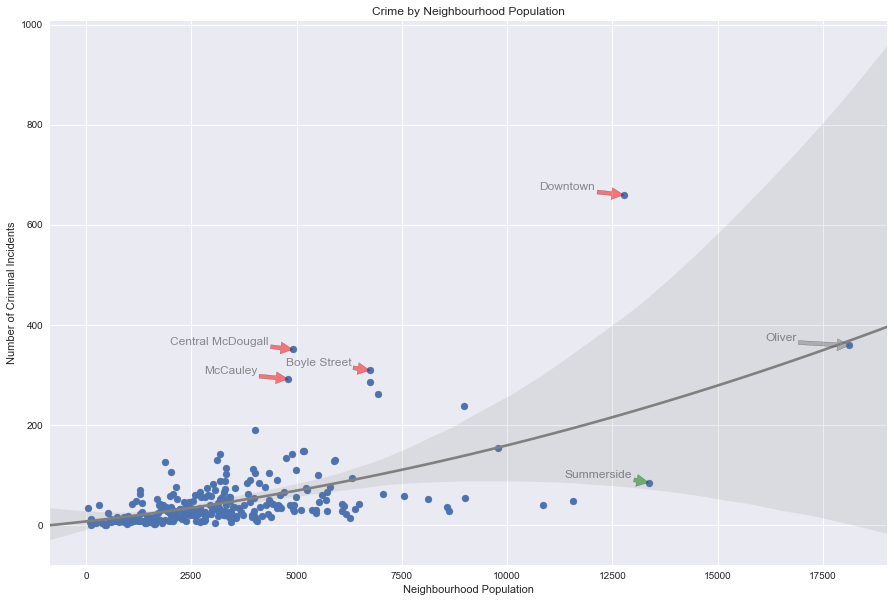

In [27]:
pop = nb_pop_assess['population']
inc = nb_pop_assess['num_incidents']

plt.figure(figsize=(15,10))

plt.scatter(pop, inc)

# Add arrow annotation
plt.annotate('Downtown', xy=(12768, 660), xytext=(10768, 660+10), arrowprops=dict(facecolor='red', alpha=0.5), alpha=0.5)
plt.annotate('Oliver', xy=(18123, 359), xytext=(16123, 359+10), arrowprops=dict(facecolor='gray', alpha=0.5), alpha=0.5)
plt.annotate('Central McDougall', xy=(4911, 351), xytext=(2000, 351+10), arrowprops=dict(facecolor='red', alpha=0.5), alpha=0.5)
plt.annotate('Boyle Street', xy=(6740, 309), xytext=(4740, 309+10), arrowprops=dict(facecolor='red', alpha=0.5), alpha=0.5)
plt.annotate('McCauley', xy=(4799, 292), xytext=(2799, 292+10), arrowprops=dict(facecolor='red', alpha=0.5), alpha=0.5)
plt.annotate('Summerside', xy=(13360, 85), xytext=(11360, 85+10), arrowprops=dict(facecolor='green', alpha=0.5), alpha=0.5)

sns.regplot(x='population', y='num_incidents', data=nb_pop_assess, color='grey', scatter=None, label='order 2', order=2)


# Add axis labels and title
plt.xlabel('Neighbourhood Population')
plt.ylabel('Number of Criminal Incidents')
plt.title('Crime by Neighbourhood Population')

plt.savefig('crime_population.png')

plt.show()

In [28]:
nb_pop_assess['crime_per_capita'] = nb_pop_assess.num_incidents / nb_pop_assess.population
nb_pop_assess[nb_pop_assess['population'] > 10000].sort_values(by='population', ascending=False)

,Assault,Break and Enter,Homicide,Robbery,Sexual Assaults,Theft From Vehicle,Theft Of Vehicle,Theft Over $5000,population,num_incidents,crime_per_capita
nb,,,,,,,,,,,
OLIVER,82,108,0,11,7,106,39,6,18123.0,359,0.019809
SUMMERSIDE,9,15,0,3,1,42,15,0,13360.0,85,0.006362
DOWNTOWN,283,102,0,41,17,166,45,6,12768.0,660,0.051692
THE HAMPTONS,10,7,0,5,4,12,10,1,11560.0,49,0.004239
RUTHERFORD,4,13,0,5,2,12,5,0,10843.0,41,0.003781


In [29]:
def my_neighbourhood(neighbourhood):
    '''This function takes a string input for the Edmonton neighbourhood in all caps.'''
    
    n_pop = df_pop.loc[neighbourhood, 'population']
    
    print('The reported crimes in 2018 for ' + neighbourhood + ' (2016 population: ' + str(n_pop) + ')\nare given by the following figure:')
    
    my_n = nb.loc[neighbourhood]
    plt.figure(figsize=(10,5))
    ax = my_n.plot(kind='barh', color='gray', title=neighbourhood + ' Criminal Incidents')
    ax.set_ylabel('Number of Crimes Reported in 2018')
    ax.xaxis.grid(True, which='major', color='w')
    plt.show()
    
    plt.clf
    
    print('The median property value change for ' + neighbourhood + '\nis given by the following figure:')
    
    plt.figure(figsize=(11,5))
    ax = history_pivot[neighbourhood].plot(color='grey', title=neighbourhood + ' Median Property Value Change', marker='.')
    ax.set_ylabel('Property Assessed Value')
    ax.set_xlabel('Year')
    ax.yaxis.grid(True, which='major', color='grey', alpha=0.2)
    plt.show()

    plt.clf
    
    pop = nb_pop_assess['population']
    inc = nb_pop_assess['num_incidents']
    x = nb_pop_assess.loc[neighbourhood, 'population']
    y = nb_pop_assess.loc[neighbourhood, 'num_incidents']
    plt.figure(figsize=(12,5))
    plt.scatter(pop, inc)
    plt.annotate(neighbourhood, xy=(x,y), xytext=(5000, 600), arrowprops=dict(facecolor='white', alpha=0.5), alpha=0.5)
    sns.regplot(x='population', y='num_incidents', data=nb_pop_assess, color='grey', scatter=None, label='order 2', order=2)

    plt.xlabel('Neighbourhood Population (2016)')
    plt.ylabel('Number of Criminal Incidents (2018)')
    plt.title('Crime (2018) by Neighbourhood Population (2016)')
    plt.show()

The reported crimes in 2018 for STARLING (2016 population: 654)
are given by the following figure:


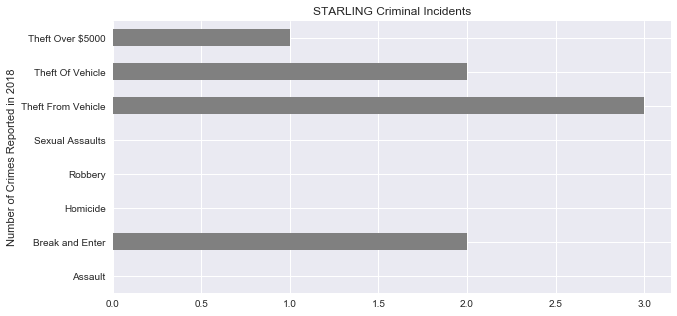

The median property value change for STARLING
is given by the following figure:


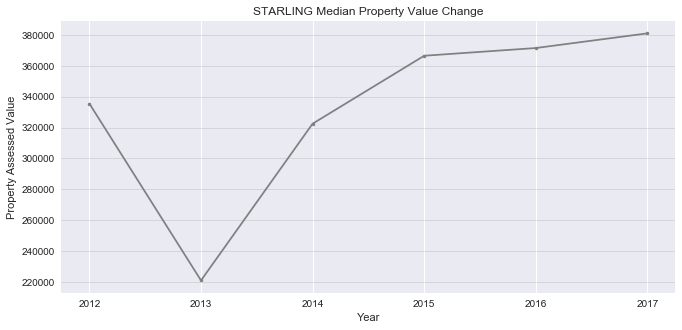

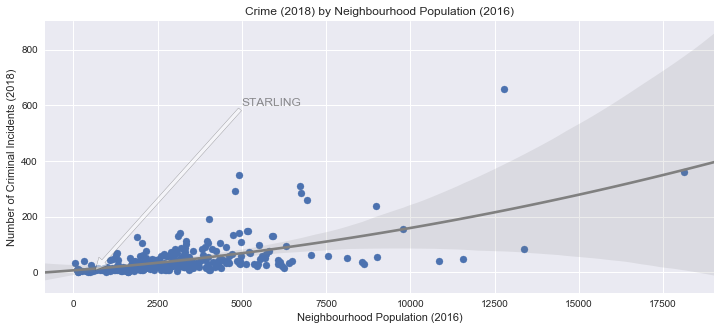

In [30]:
my_neighbourhood('STARLING')

In [22]:
df_pop_crime = property_assess.merge(df_pop, how='left', on='nb')


In [23]:
df_capita_crime = df_clean.merge(nb_pop_assess, left_on='nb', right_index=True)

In [24]:
df_capita_crime.sort_values(by=['crime_per_capita', 'value'])
capita_crime = df_capita_crime.dropna(subset=['population', 'crime_per_capita'])

slope = -41781.806480493506 CAD/1 crime per 100 residents
intercept = 418879.68413004576 CAD


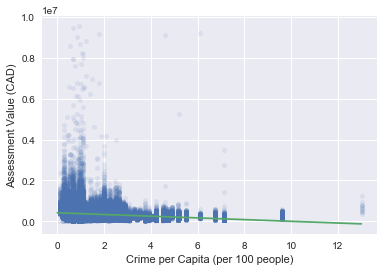

In [34]:
value = np.array(capita_crime['value'][:-15])
crime = np.array(capita_crime['crime_per_capita'][:-15] * 100)
_ = plt.plot(crime, value, marker='.', linestyle='none', alpha=0.1, markersize=10)
_ = plt.xlabel('Crime per Capita (per 100 people)')
_ = plt.ylabel('Assessment Value (CAD)')

# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(crime, value, 1)

# Print the results to the screen
print('slope =', a, 'CAD/1 crime per 100 residents')
print('intercept =', b, 'CAD')

# Make theoretical line to plot
x = np.array([0, 13])
y = a * x + b

# Add regression line to your plot
_ = plt.plot(x, y)

plt.show()

In [35]:
np.random.seed(42)
# Compute observed correlation: r_obs
r_obs = pearson_r(crime, value)

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute illiteracy measurments: illiteracy_permuted
    crime_permuted = np.random.permutation(crime)

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(crime_permuted, value)

# Compute p-value: p
p = np.sum(perm_replicates >= r_obs) / len(perm_replicates)
print('p-val =', p)

p-val = 1.0


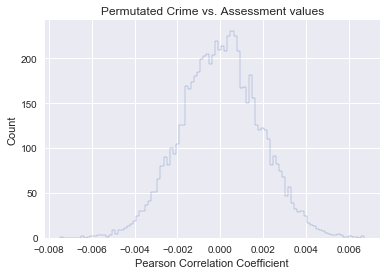

observed pearson coefficient -0.2175636971671757


In [36]:
_ = plt.hist(perm_replicates, bins=int(np.sqrt(len(perm_replicates))), density=True, histtype='step')
_ = plt.xlabel('Pearson Correlation Coefficient')
_ = plt.ylabel('Count')
_ = plt.title('Permutated Crime vs. Assessment values')

plt.show()

print('observed pearson coefficient', r_obs)

In [30]:
print('population mean assessment:', np.mean(df_clean['value']))

population mean assessment: 365160.202031663


In [29]:
df_garage = df_clean[df_clean['garage'] == True]
df_no_garage = df_clean[~df_clean['garage'] == True]
print('with garage mean assessment:', np.mean(df_garage.value), '\nno garage mean assessment:', np.mean(df_no_garage.value))

with garage mean assessment: 430575.3893830812 
no garage mean assessment: 207761.48337595907
